This notebook compares 3 basic ways to approximate (and thus in some loose sense "compress") images:
- Reducing the number of pixels by averaging on squares, 
- Keeping the low-frequency Fourier coefficients, 
- Keeping the largest Wavelet coefficients.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
import pywt # to compute wavelet transforms

Load an image from the internet. The image has range of value [0,1].

In [2]:
def preprocess(f,n):
  n0 = np.min( f.size )
  f = f.crop((0, 0, n0, n0))
  f = f.resize((n, n))
  f = np.array(f)
  f = np.clip(f / np.max(f.flatten()), 0,1)
  return f

In [3]:
from urllib.request import urlopen
import io
n = 512 # target size
file_adress = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Tabby_cat_with_blue_eyes-3336579.jpg/639px-Tabby_cat_with_blue_eyes-3336579.jpg'
fd = urlopen(file_adress)
image_file = io.BytesIO(fd.read())
f = Image.open(image_file)
f = preprocess( f, n )

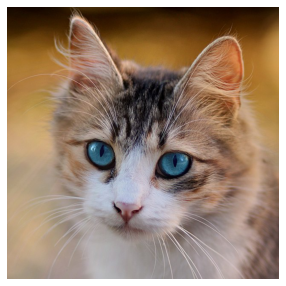

In [4]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.imshow(f)
plt.axis('off');

In [6]:
def approx_pixels(f,r):
  p = int( n*np.sqrt(r) )
  f = Image.fromarray( np.uint8(f*255) )
  f = f.resize((p, p), Image.NEAREST )
  f = f.resize((n, n), Image.NEAREST )
  f = np.array(f)/255.0
  return np.clip(f,0,1) 

In [7]:
def approx_fourier(f,r):
  m = int(r*n*n)
  # compute a 1D indexing from low to high frequencies
  x = np.concatenate( (np.arange(0,int(n/2)), np.arange(-int(n/2),0)) )
  D = x[:,None]**2 + x[None,:]**2
  mask = D<np.sort(D.flatten())[m]
  # inverse the masked FFT
  F = np.fft.fft2(f,axes=(0,1))
  F = F * mask[:,:,None]
  fM = np.real(np.fft.ifft2(F,axes=(0,1)))
  return np.clip(fM,0,1), np.fft.fftshift(mask)

In [8]:
def approx_wavelets(f,r):
  m = int(r*n*n)
  wavetype = 'bior3.5'
  nlvel = int( np.floor(np.log2(n))-3 )
  f1 = np.zeros( f.shape );
  for k in range(3):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore") # pywlet issue a warning for too low level decomposition
      fW = pywt.wavedec2(f[:,:,k], wavetype, level=nlvel)
    # turn coefficient into a convenient array
    fWI, coeff_slices = pywt.coeffs_to_array(fW)
    D = np.sort( np.abs(fWI.flatten()) ) # sorted coefficients magnitude
    fWI = fWI * (abs(fWI)>D[-m-1]) # threshold
    fW1 = pywt.array_to_coeffs(fWI,coeff_slices, output_format='wavedec2')
    f1[:,:,k] = pywt.waverec2( fW1, wavetype)
  mask = (abs(fWI)>D[-m-1])
  return np.clip(np.array(f1),0,1), mask

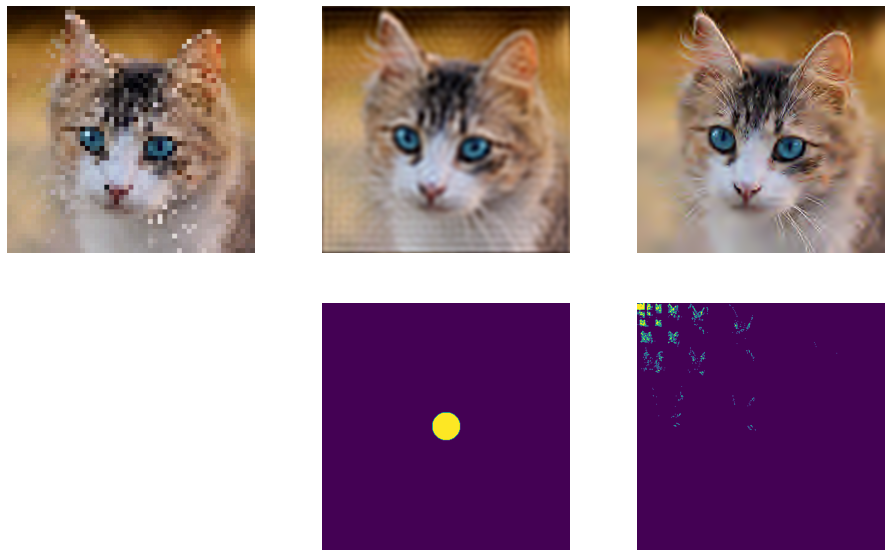

In [9]:
def render_display(r):
  fP = approx_pixels(f,r)
  fF, mF = approx_fourier(f,r)
  fW, mW = approx_wavelets(f,r)
  plt.rcParams['figure.figsize'] = [16, 10]
  plt.subplot(2,3,1)
  plt.imshow(fP)
  plt.axis('off')
  plt.subplot(2,3,2)
  plt.imshow(fF)
  plt.axis('off')
  plt.subplot(2,3,3)
  plt.imshow(fW)
  plt.axis('off')
  plt.subplot(2,3,5)
  plt.imshow(mF)
  plt.axis('off')
  plt.subplot(2,3,6)
  plt.imshow(mW)
  plt.axis('off')

r = .01 # compressio ratio
render_display(r)

In [10]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [11]:
@interact(r=(0.01/2,0.1,0.01/2))
def h(r=.05):
    render_display(r)

interactive(children=(FloatSlider(value=0.05, description='r', max=0.1, min=0.005, step=0.005), Output()), _do…